<a href="https://colab.research.google.com/github/CamiloVga/Curso-Inteligencia-Artificial/blob/main/Clase_FineTuning_Clasificador_BaseStreaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase Fine Tuning con base en streaming desde HuggingFace


Este script muestra cómo hacer fine-tuning a un modelo clasificador Bert Case con una base extraída en streaming desde HuggingFace.

Por:[ Camilo Vega
](https://www.linkedin.com/in/camilo-vega-169084b1/)


In [2]:
!pip install torch transformers datasets scikit-learn

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00


In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Cargar el dataset completo (sin streaming para obtener todas las muestras)
dataset = load_dataset("mteb/amazon_reviews_multi", "es", split="train")

# Contar cuántas muestras tiene cada clase
class_counts = defaultdict(int)
for sample in dataset:
    class_counts[sample['label']] += 1

print("Distribución de clases antes de balancear:", class_counts)

# Tomar un número igual de muestras por clase (por ejemplo, 100 por clase)
samples_per_class = 100
balanced_samples = []

# Organizar el dataset por clase
class_samples = defaultdict(list)
for sample in dataset:
    class_samples[sample['label']].append(sample)

# Seleccionar aleatoriamente las muestras para balancear
for label, samples in class_samples.items():
    if len(samples) >= samples_per_class:
        balanced_samples.extend(random.sample(samples, samples_per_class))
    else:
        print(f"Advertencia: La clase {label} tiene menos de {samples_per_class} muestras ({len(samples)} disponibles).")
        balanced_samples.extend(samples)  # Tomar todas las muestras si no hay suficientes

# Extraer textos y etiquetas balanceadas
texts = [sample['text'] for sample in balanced_samples]
labels = [sample['label'] for sample in balanced_samples]

# Codificar las etiquetas
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Ver una muestra del dataset balanceado y su distribución final de clases
print("Distribución de clases después de balancear:", dict(zip(label_encoder.classes_, [list(encoded_labels).count(i) for i in range(len(label_encoder.classes_))])))
print("Ejemplo de datos balanceados:")
for i in range(5):  # Muestra de 5 entradas del dataset
    print(f"Texto: {texts[i]}\nEtiqueta (codificada): {encoded_labels[i]}\n")

# Cargar el tokenizer y el modelo
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenizar los textos
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Preparar el dataset de PyTorch
class AmazonReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Cambiar a long para clasificación multiclase
        return item

    def __len__(self):
        return len(self.labels)


dataset = AmazonReviewsDataset(tokenized_inputs, encoded_labels)



0000.parquet:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

es/validation/0000.parquet:   0%|          | 0.00/613k [00:00<?, ?B/s]

es/test/0000.parquet:   0%|          | 0.00/619k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Distribución de clases antes de balancear: defaultdict(<class 'int'>, {0: 40000, 1: 40000, 2: 40000, 3: 40000, 4: 40000})
Distribución de clases después de balancear: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}
Ejemplo de datos balanceados:
Texto: No lo volvería a comprar

Muy malo, a las 2semanas de uso ya había cascado.
Etiqueta (codificada): 0

Texto: malo malo...

lo compre como luces para bailar en navidad y solo funciono una semana, ahora el peque se quedo sin luces navideñas disco, estaban chulas pero no duraron muy poco
Etiqueta (codificada): 0

Texto: Alberto

Una mierda, ha dejado de funcionar a la media hora y ya no hay forma de hacerlo funcionar, UN TIMO.
Etiqueta (codificada): 0

Texto: Los palos son muy cortos.

Los palos son muy cortos, no me lo he podido poner, se los he dado para mí hija pequeña, es una lastima.
Etiqueta (codificada): 0

Texto: Sin almohadillas

Buena calidad y buen sonido pero han llegado sin almohadillas y asi es imposible mantenerlos en la oreja. Una l

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


max_steps is given, it will override any value given in num_train_epochs
<ipython-input-3-d6206b64c166>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
5,1.398300
10,1.378600
15,1.346500
20,1.298600
25,1.329600
30,1.316800
35,1.348700
40,1.308100
45,1.270600
50,1.252800


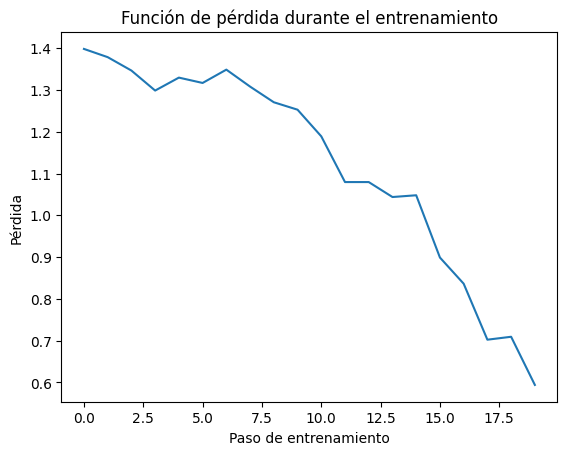

Entrenamiento completado y modelo guardado.


In [9]:
# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  # Directorio para guardar los resultados del modelo.
    num_train_epochs=3,  # Número de épocas o ciclos completos sobre el conjunto de datos.
    per_device_train_batch_size=16,  # Tamaño del lote por dispositivo (GPU/CPU) durante el entrenamiento.
    warmup_steps=200,  # Número de pasos de calentamiento para aumentar progresivamente la tasa de aprendizaje.
    weight_decay=0.01,  # Tasa de descomposición de pesos para prevenir sobreajuste (regularización).
    learning_rate=5e-5,  # Tasa de aprendizaje, que determina el tamaño de los pasos de actualización.
    logging_dir="./logs",  # Directorio para almacenar los registros del entrenamiento.
    logging_steps=5,  # Frecuencia con la que se registran los resultados (cada cuántos pasos).
    report_to="none",  # Desactivar reportes a herramientas externas como WandB.
    gradient_accumulation_steps=4,  # Acumular gradientes durante 4 pasos antes de la actualización de parámetros.
    max_steps=100  # Número máximo de pasos de entrenamiento; se puede ajustar según sea necesario.
)

# Definir una función para registrar la pérdida durante el entrenamiento
class LossRecorder(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_loss = []

    def log(self, logs):
        # Registro de la pérdida
        if "loss" in logs:
            self.training_loss.append(logs["loss"])
        super().log(logs)

# Iniciar el entrenamiento
trainer = LossRecorder(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

# Guardar el modelo
trainer.save_model("./fine_tuned_bert_amazon_reviews")

# Verificar si la lista de pérdidas tiene valores
if len(trainer.training_loss) > 0:
    # Graficar la pérdida
    plt.plot(trainer.training_loss)
    plt.title('Función de pérdida durante el entrenamiento')
    plt.xlabel('Paso de entrenamiento')
    plt.ylabel('Pérdida')
    plt.show()
else:
    print("No se registraron valores de pérdida durante el entrenamiento.")

print("Entrenamiento completado y modelo guardado.")


In [10]:
# Asegurarse de que el modelo esté en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función de inferencia usando el modelo entrenado
def inferencia_nueva_entrada(prompt, model, tokenizer):
    # Tokenizar el prompt y mover los tensores al dispositivo correcto
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Realizar la inferencia
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtener las predicciones
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Decodificar la predicción (ajustar según el dataset usado)
    if predicted_class == 0:
        return "Etiqueta: Muy Negativa"
    elif predicted_class == 1:
        return "Etiqueta: Negativa"
    elif predicted_class == 2:
        return "Etiqueta: Neutra"
    elif predicted_class == 3:
        return "Etiqueta: Positiva"
    elif predicted_class == 4:
        return "Etiqueta: Muy Positiva"
    else:
        return "Etiqueta desconocida"

# Ejemplo de uso del módulo de inferencia después del entrenamiento
nuevo_prompt = "Me encanta es dispositivo"
resultado = inferencia_nueva_entrada(nuevo_prompt, model, tokenizer)
print(f"Resultado del modelo: {resultado}")



Resultado del modelo: Etiqueta: Positiva
